# Retrieval Augmented Generation (RAG) using FAISS vector database and Gemma instruction tuned models for movies.

In [1]:
!pip install -q accelerate bitsandbytes transformers sentence-transformers faiss-gpu datasets langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.3/297.3 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.8/812.8 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.8/276.8 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [2]:
from datasets import load_dataset
import pandas as pd
from tqdm.notebook import tqdm

#get movies dataset
dataset = load_dataset("MongoDB/embedded_movies")
dataset_df = pd.DataFrame(dataset['train'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

In [3]:
#display top 5 rows
dataset_df.head()

,plot,countries,runtime,cast,languages,type,plot_embedding,num_mflix_comments,poster,title,genres,metacritic,awards,directors,rated,writers,imdb,fullplot
0,Young Pauline is left a lot of money when her ...,[USA],199.0,"[Pearl White, Crane Wilbur, Paul Panzer, Edwar...",[English],movie,"[0.00072939653, -0.026834568, 0.013515796, -0....",0,https://m.media-amazon.com/images/M/MV5BMzgxOD...,The Perils of Pauline,[Action],NaN,"{'nominations': 0, 'text': '1 win.', 'wins': 1}","[Louis J. Gasnier, Donald MacKenzie]",None,"[Charles W. Goddard (screenplay), Basil Dickey...","{'id': 4465, 'rating': 7.6, 'votes': 744}",Young Pauline is left a lot of money when her ...
1,A penniless young man tries to save an heiress...,[USA],22.0,"[Harold Lloyd, Mildred Davis, 'Snub' Pollard, ...",[English],movie,"[-0.022837115, -0.022941574, 0.014937485, -0.0...",0,https://m.media-amazon.com/images/M/MV5BNzE1OW...,From Hand to Mouth,"[Comedy, Short, Action]",NaN,"{'nominations': 1, 'text': '1 nomination.', 'w...","[Alfred J. Goulding, Hal Roach]",TV-G,[H.M. Walker (titles)],"{'id': 10146, 'rating': 7.0, 'votes': 639}",As a penniless man worries about how he will m...
2,"Michael ""Beau"" Geste leaves England in disgrac...",[USA],101.0,"[Ronald Colman, Neil Hamilton, Ralph Forbes, A...",[English],movie,"[0.00023330493, -0.028511643, 0.014653289, -0....",0,None,Beau Geste,"[Action, Adventure, Drama]",NaN,"{'nominations': 0, 'text': '1 win.', 'wins': 1}",[Herbert Brenon],None,"[Herbert Brenon (adaptation), John Russell (ad...","{'id': 16634, 'rating': 6.9, 'votes': 222}","Michael ""Beau"" Geste leaves England in disgrac..."
3,"Seeking revenge, an athletic young man joins t...",[USA],88.0,"[Billie Dove, Tempe Pigott, Donald Crisp, Sam ...",None,movie,"[-0.005927917, -0.033394486, 0.0015323418, -0....",1,https://m.media-amazon.com/images/M/MV5BMzU0ND...,The Black Pirate,"[Adventure, Action]",NaN,"{'nominations': 0, 'text': '1 win.', 'wins': 1}",[Albert Parker],None,"[Douglas Fairbanks (story), Jack Cunningham (a...","{'id': 16654, 'rating': 7.2, 'votes': 1146}",A nobleman vows to avenge the death of his fat...
4,An irresponsible young millionaire changes his...,[USA],58.0,"[Harold Lloyd, Jobyna Ralston, Noah Young, Jim...",[English],movie,"[-0.0059373598, -0.026604708, -0.0070914757, -...",0,https://m.media-amazon.com/images/M/MV5BMTcxMT...,For Heaven's Sake,"[Action, Comedy, Romance]",NaN,"{'nominations': 1, 'text': '1 nomination.', 'w...",[Sam Taylor],PASSED,"[Ted Wilde (story), John Grey (story), Clyde B...","{'id': 16895, 'rating': 7.6, 'votes': 918}","The Uptown Boy, J. Harold Manners (Lloyd) is a..."


In [4]:
#discard rows that do not have "fullplot" information
dataset_df = dataset_df.dropna(subset=["fullplot"])
#We will need only 'fullplot' 'title' and 'genres' information
main_dataset_df = dataset_df[["fullplot", "title", "genres"]]

In [5]:
main_dataset_df.head()

,fullplot,title,genres
0,Young Pauline is left a lot of money when her ...,The Perils of Pauline,[Action]
1,As a penniless man worries about how he will m...,From Hand to Mouth,"[Comedy, Short, Action]"
2,"Michael ""Beau"" Geste leaves England in disgrac...",Beau Geste,"[Action, Adventure, Drama]"
3,A nobleman vows to avenge the death of his fat...,The Black Pirate,"[Adventure, Action]"
4,"The Uptown Boy, J. Harold Manners (Lloyd) is a...",For Heaven's Sake,"[Action, Comedy, Romance]"


In [6]:
from langchain_community.document_loaders import DataFrameLoader

#convert DataFrane into Langchain Document format for further processing
#"fullplot" will be the main content information, "title" and "generes" will be used as metadata
loader = DataFrameLoader(main_dataset_df, page_content_column="fullplot")
dataset_docs = loader.load()

In [7]:
#chunking using embedding model
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

#hierarchy of seperators to be used by text splitter
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

#"thenlper/gte-small" with 512 dimentional embedding is used as embedding model
EMB_MODEL_CKP = "thenlper/gte-small"
#get enbedding_tokenizer
embedding_tokenizer = AutoTokenizer.from_pretrained(EMB_MODEL_CKP)

def split_documents(chunk_size, KB, tokenizer=embedding_tokenizer):
  """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
  """
  text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        embedding_tokenizer, #tokenizer to be used to determine number of tokens
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True, # If `True`, includes chunk's start index in metadata
        strip_whitespace=True, # If `True`, strips whitespace from the start and end of every document
        separators=MARKDOWN_SEPARATORS, #use seperators for chunking
    )

  docs_processed = []
  for doc in KB:
      docs_processed += text_splitter.split_documents([doc])

  #remove duplicates
  unique_texts = {}
  docs_processed_unique = []
  for doc in tqdm(docs_processed):
    if doc.page_content not in unique_texts:
      unique_texts[doc.page_content] = True
      docs_processed_unique.append(doc)

  return docs_processed_unique

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [8]:
#split documents
docs_processed_tok = split_documents(512, dataset_docs, EMB_MODEL_CKP)

  0%|          | 0/2125 [00:00<?, ?it/s]

  0%|          | 0/1452 [00:00<?, ?it/s]

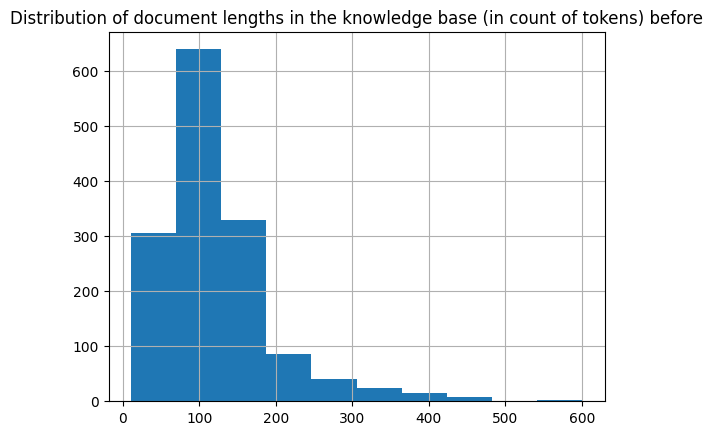

  0%|          | 0/2057 [00:00<?, ?it/s]

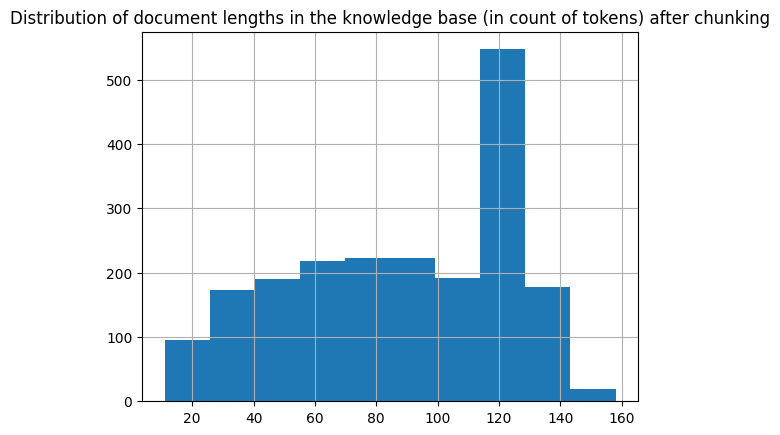

In [9]:
# Let's visualize the chunk sizes we would have in tokens from a common model
import matplotlib.pyplot as plt

lengths = [len(embedding_tokenizer.encode(doc.page_content)) for doc in tqdm(dataset_docs)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens) before")
plt.show()

lengths = [len(embedding_tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed_tok)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens) after chunking")
plt.show()

# Building Vector Database using FAISS
**Nearest Neighbour Search**
 - GTE embeddings work well with `cosine similarity`
 - for other methods (if vectors are not normalized) try:
  - `Dot product`
  - `Euclidean Distance`

In [10]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy


embedding_model = HuggingFaceEmbeddings(
    model_name = EMB_MODEL_CKP,
    multi_process = True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # set True for cosine similarity
)

#create FAISS indices for approximate nearest neighbour search
KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    dataset_docs, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [11]:
def get_search_result(query, vector_db):
  """
  given a "query" search for top k "fullplots" embedded in vector database
  """
  #get top k documents similar to "query"
  retrieved_docs = vector_db.similarity_search(query=user_query, k=3)
  search_result = ""
  for result in retrieved_docs:
      retrieved_plot = result.page_content if result.page_content else "N/A"
      retrieved_title = result.metadata['title'] if result.metadata['title'] else "N/A"
      retrieved_genre = result.metadata['genres'] if result.metadata['genres'] else "N/A"
      search_result += f"Title: {retrieved_title}, Plot: {retrieved_plot} , Genres: {retrieved_genre}\n" #add Title, Plot and Genres to the context string

  return search_result

# Load Gemma instructction tuned model

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [13]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b-it")
# CPU Enabled uncomment below 👇🏽
# model = AutoModelForCausalLM.from_pretrained("google/gemma-2b-it")
# GPU Enabled use below 👇🏽
model = AutoModelForCausalLM.from_pretrained("google/gemma-2b-it", device_map="auto")

tokenizer_config.json:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/888 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [61]:
# Conduct query with retrieval of sources
user_query = "What is a good romance movie to watch and why?"
retrieved_results = get_search_result(user_query, KNOWLEDGE_VECTOR_DATABASE)
combined_information = f"Answer the following query using the provided context. Please provide the movie title in the begining.\n <CONTEXT>:\n{retrieved_results}. \n <QUERY>: {user_query}"

#chat template for gemma model conversation
chat = [
    { "role": "user", "content": combined_information },
]
prompt = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)

In [63]:
# Moving tensors to GPU
input_ids = tokenizer(combined_information, return_tensors="pt").to("cuda")

pipe = pipeline(model=model,
                tokenizer = tokenizer,
                task="text-generation",
                return_full_text=False,
                max_new_tokens=500,
                do_sample=True,
                temperature=2.1,
                top_k=50,
                top_p=1,
                #repetition_penalty=1.1,
                num_return_sequences=1,
                #add_special_tokens=True,
                )
print(f"Query: {user_query}\n")
print(pipe(prompt)[0]["generated_text"])

Query: What is a good romance movie to watch and why?

The movie 'Titanic' is a popular romantic epic, that follows the romance of lovers Isabella Paradis(Catherine Zeta Jones) and James Cameron (Leonardo DiCaprio). They relive a romantic experience together decades after. The beautiful music by Celine Dion and the stunning visuals combined to be memorable making it  such an extraordinary.


In [64]:
combined_information

"Answer the following query using the provided context. Please provide the movie title in the begining.\n <CONTEXT>:\nTitle: Titanic, Plot: The plot focuses on the romances of two couples upon the doomed ship's maiden voyage. Isabella Paradine (Catherine Zeta-Jones) is a wealthy woman mourning the loss of her aunt, who reignites a romance with former flame Wynn Park (Peter Gallagher). Meanwhile, a charming ne'er-do-well named Jamie Perse (Mike Doyle) steals a ticket for the ship, and falls for a sweet innocent Irish girl on board. But their romance is threatened by the villainous Simon Doonan (Tim Curry), who has discovered about the ticket and makes Jamie his unwilling accomplice, as well as having sinister plans for the girl. , Genres: ['Action', 'Drama', 'History']\nTitle: Shut Up and Kiss Me!, Plot: Ryan and Pete are 27-year old best friends in Miami, born on the same day and each searching for the perfect woman. Ryan is a rookie stockbroker living with his psychic Mom. Pete is a s

In [68]:
# Conduct query with retrieval of sources
user_query = "What pirate adventure movie mentions Jack Sparrow and what is the plot?"
retrieved_results = get_search_result(user_query, KNOWLEDGE_VECTOR_DATABASE)
combined_information = f"Answer the following query using the provided context. Please provide the movie title in the begining.\n <CONTEXT>:\n{retrieved_results}. \n <QUERY>: {user_query}"

#chat template for gemma model conversation
chat = [
    { "role": "user", "content": combined_information },
]
prompt = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)

In [71]:
# Moving tensors to GPU
input_ids = tokenizer(combined_information, return_tensors="pt").to("cuda")

pipe = pipeline(model=model,
                tokenizer = tokenizer,
                task="text-generation",
                return_full_text=False,
                max_new_tokens=500,
                do_sample=True,
                temperature=2.1,
                #top_k=50,
                #top_p=1,
                #repetition_penalty=1.1,
                num_return_sequences=1,
                #add_special_tokens=True,
                )
print(f"Query: {user_query}\n")
print(pipe(prompt)[0]["generated_text"])

Query: What pirate adventure movie mentions Jack Sparrow and what is the plot?

**Title: Pirates of the Caribbean: The Curse of the Black Pearl, Plot:**
This blockbuster follows the epic voyage of Captain Jack Sparrow and Will Turner as they tirelessly search for Elizabeth Swann captured by Barbossa, leader of an insidious cursed crew who needs souls or lives are permanently eradicated with each generation. Along the way, pirates clash in bloody fight choreographed battles reminiscent of "Dead Man's Chest". His relentless pursuit culminates the fateful death of The Beast with the Kraken


In [72]:
retrieved_results

'Title: Pirates of the Caribbean: The Curse of the Black Pearl, Plot: This swash-buckling tale follows the quest of Captain Jack Sparrow, a savvy pirate, and Will Turner, a resourceful blacksmith, as they search for Elizabeth Swann. Elizabeth, the daughter of the governor and the love of Will\'s life, has been kidnapped by the feared Captain Barbossa. Little do they know, but the fierce and clever Barbossa has been cursed. He, along with his large crew, are under an ancient curse, doomed for eternity to neither live, nor die. That is, unless a blood sacrifice is made. , Genres: [\'Action\', \'Adventure\', \'Fantasy\']\nTitle: Pirates of the Caribbean: Dead Man\'s Chest, Plot: Once again we\'re plunged into the world of sword fights and "savvy" pirates. Captain Jack Sparrow is reminded he owes a debt to Davy Jones, who captains the flying Dutchman, a ghostly ship, with a crew from hell. Facing the "locker" Jack must find the heart of Davy Jones but to save himself he must get the help o